# Módulo 3 - Medindo Retornos e Risco

In [ ]:
# Dados
using CSV              # Gravação/leitura de ficheiros em formato CSV
using DataFrames       # Tabelas
using Dates            # Datas

# Gráficos
using StatsPlots       # Gráficos 

# Estatistica
using ARCHModels       # Modelos GARCH
using Distributions    # Distribuições de probabilidade
using HypothesisTests  # Testes de hipóteses
using Random           # Simulação de variáveis aleatórias
using Statistics       # Estatística descritiva, inclui cálculo de quantis

# Matemática
using LinearAlgebra    # Álgebra linear

Foi criada uma aplicação em Julia especialmente para a disciplina de Gestão de Riscos Financeiros chamada GRF.jl. Para a instalar podemos fazer, 

In [ ]:
#import Pkg
#Pkg.add(url = "https://github.com/ASaragga/GRF.jl")
using GRF

#### Dados

Ler ficheiros com (i) retornos das açoes incluidas no índice Dow Jones, assim como (Ii) um conjunto suplementar de ações (e.g. Tesla)

In [ ]:
DJ30r = CSV.read("/Users/antonio/Documents/Universidade/GRF-2022/Dados/DJ30r.csv", DataFrame);
DIVr = CSV.read("/Users/antonio/Documents/Universidade/GRF-2022/Dados/DIVr.csv", DataFrame);

In [ ]:
Datas = DJ30r[!,:Data];
JPMorgan = DJ30r[!, :JPM];  # JP Morgan
PG = DJ30r[!, :PG];         # Procter & Gamble
Tesla = DIVr[!, :TSLA];     # Tesla

### Medida de Risco Total: Volatilidade 

A volatilidade é o grau de dispersão de uma série cronológica de preços ao longo do tempo, geralmente medida pelo desvio padrão dos retornos logarítmicos.

In [ ]:
plot(Datas, JPMorgan, legend = false, ylabel = "Retornos diários JP Morgan", framestyle=:box)

In [ ]:
plot(Datas, PG, legend = false, ylabel = "Retornos diários Procter & Gamble", framestyle=:box)

In [ ]:
plot(Datas, Tesla, legend = false, ylabel = "Retornos diários Tesla", framestyle=:box)

In [ ]:
println("σ(J.P.Morgan) = ", std(JPMorgan))
println("σ(Procter & Gamble) = ", std(PG))
println("σ(Tesla) = ",std(Tesla))

### 1.2.2. Medidas de Risco de Perda: Valor-em-Risco (VaR) e Perda Esperada na Cauda (ETL)

O **Valor-em-Risco**, ou VaR (*Value-at-Risk*) a um nível (α%), mede qual será a nossa perda mínima no caso de perdas tão severas que ocorrem apenas (α) por cento do tempo.

A **Perda Esperada na Cauda**, ou ETL (*Expected Tail Loss*) a um nível (α%), mede qual será a nossa perda média no caso de perdas tão severas que ocorrem apenas (α) por cento do tempo. O ETL também é frequentemente denominado como *Expected Shortfall* (ES) ou *Conditional Value-at-Risk* (CVaR).

Para uma dada carteira, as medidas de risco VaR e ETL são calculadas considerando (i) o valor atual ($V_0$) da carteira, (ii) um horizonte temporal ($T$), assim como (iii) um determinado quantil ($\alpha$) de perdas, e (iv) pressupõem uma determinada distribuição de probabilidade (empírica ou analítica) para os retornos. 

$$\text{VaR}(V_0,T,α):\quad \mathbb{P}[\Delta V_T < - \text{VaR}] = \alpha$$

$$\text{ETL}(V_0,T,α):\quad \mathbb{E}[\Delta V_T \mid \Delta V_T < - \text{VaR}] = \alpha$$

Exemplo:
* VaR(T=1 dia, α=5%) = 50 000 Eur, significa que existe uma probabilidade de 5% de num dia a carteira vir a ter uma perda superior a 50 000 Eur. 
* ETL(T=1 dia, α=5%) = 65 000 Eur, significa que para os 5% piores desempenhos diários, a carteira irá ter uma perda em média superior a 65 000 Eur.

As medidas de risco VaR e ETL têm quatro usos principais em finanças:
* gestão de risco
* controlo financeiro
* relato financeiro 
* cálculo do capital regulatório

## 1.3. Determinação do VaR e ETL

Metodologias:
 * Abordagem empírica por simulação histórica
 * Abordagem paramétrica por simulação de Monte-Carlo
 * Abordagem paramétrica pelo método analítico

In [ ]:
# Nos exemplos seguintes, o valor da carteira V = 1 000 000 USD e o α = 5.0%
V = 1_000_000;  
α = 0.05;

### Simulação histórica

#### VaR

In [ ]:
# Definição do VaR ao nível de significância α ou nível de confiança (1-α)
VaR(retornos, α, V) = - (quantile(retornos,α) - mean(retornos)) * V

In [ ]:
println("VaR(JPMorgan) = ", VaR(JPMorgan, α, V), " USD")
println("VaR(Procter & Gamble) = ", VaR(PG, α, V), " USD")
println("VaR diário Tesla = ", VaR(Tesla, α, V), " USD")

#### ETL

In [ ]:
function ETL(retornos, alfa, V)
    nobs = length(retornos)
    corte = quantile(retornos, alfa)
    excedimentos = 0
    n_excedimentos = 0
    for i in 1:nobs
        if retornos[i] <= corte
            excedimentos += retornos[i]
            n_excedimentos += 1
        end
    end
    return - (excedimentos/n_excedimentos - mean(retornos)) * V
end

Cálculo da perda esperada na cauda diária por simulação histórica 

In [ ]:
alfa = 0.05
V = 1_000_000
println("ETL(JP Morgan) = USD ", ETL(JPMorgan, alfa, V))
println("ETL(Procter & Gamble) = USD ", ETL(PG, alfa, V))
println("ETL(Tesla) = USD ", ETL(Tesla, alfa, V))

### Simulação de Monte-Carlo

Distribuição, parâmetros estimados → Séries temporais simuladas de retornos → VaR, ETL

- Estimar parâmetros da distribuição escolhida. Neste exemplo, iremos escolher uma distribuição Normal - que assumimos bem caracterizar a distribuição dos retornos - e estimar os seus parâmetros (μ, σ)
- Utilizando a distribuição estimada, simulamos os retornos e a partir desses valores simulados calculamos o VaR

**Exemplo** Pretendemos obter estimativas para os VaRm diários com α=5%, de três carteiras no montante de EUR 500 000 de ações JP Morgan, Procter & Gamble e Tesla através da abordagem paramétrica por simulação de Monte-Carlo, assumindo distribuições Normais para os retornos das ações.

In [ ]:
alfa = 0.05
V = 500_000
vJPMorgan = std(JPMorgan);
vPG = std(PG);
vTesla = std(Tesla);

De seguida, utilizando a função $\texttt{rand}$, simulamos 5000 retornos diários gerados por distribuições Normais com médias zero e desvios-padrão iguais às volatilidades atrás calculadas,

In [ ]:
simJPMorgan = rand(Normal(0, vJPMorgan), 5000)
simPG = rand(Normal(0, vPG), 5000)
simTesla = rand(Normal(0, vTesla), 5000)

Com base nos retornos simulados iremos agora calcular os VaR, de forma semelhante ao que fizemos através de simulação histórica. A diferença, claro, é que agora se tratam de retornos simulados e não de retornos históricos,

In [ ]:
println("VaR(JP Morgan) = USD ", VaR(simJPMorgan, alfa, V))
println("VaR(Procter & Gamble) = USD ", VaR(simPG, alfa, V))
println("VaR(Tesla) = USD ", VaR(simTesla, alfa, V))

Uma vez obtidas as séries cronológicas para os retornos simulados das ações JP Morgan, Procter \& Gamble e Tesla, podemos agora determinar o ETL por simulação de Monte-Carlo, também de forma semelhante ao que fizemos através da simulação histórica.

In [ ]:
println("ETL(JP Morgan) = USD ", ETL(simJPMorgan, alfa, V))
println("ETL(Procter & Gamble) = USD ", ETL(simPG, alfa, V))
println("ETL(Tesla) = USD ", ETL(Tesla, alfa, V))

### Método analítico

Normalmente o VaR e ETL são calculados para horizontes temporais curtos, de 1-10 dias úteis. Uma vez que $\mu_T\approx 0$ e não existe uma forma objectiva de determinar $\mu_T$,  é comum assumir-se que $\mu_T = 0$. Nas análises subsequentes, tal como fizemos nas análises anteriores, iremos pois também assumir que o retorno esperado da carteira é igual a zero, ou seja que $\mu_T = 0$, e que portanto o $\text{VaR}_m$ e $\text{VaR}_0$ coincidem.

Dado $\mu_T = 0$, nas abordagens paramétricas (método analítico e simulação de Monte-Carlo) a distribuição prospetiva de retornos $r_T$ será,
$$r_T \sim \sigma_T\times \text{Distribuição}(0, 1)$$ 
Se a distribição for Normal, estaremos perante uma Normal standard. Assim, podemos exprimir o VaR da seguinte forma equivalente

$$\text{VaR} = - \text{quantil}_\alpha[r_T]  \times V_0 = - \sigma_T \times \text{quantil}_\alpha[\text{Distribuição}(0,1)]  \times V_0$$

Se não tivéssemos disponível a aplicação Julia, poderíamos nos socorrer de tabelas estatísticas que tabelam os quantis de distribuições padronizadas. Assim para as distribuições Normal e T-Student(6) padronizadas obteríamos os seguintes valores críticos $z_\alpha\equiv\text{quantil}_\alpha[\text{Distribuição}(0,1)]$

 quantil |    Nomal     | T-Student(6)
---------------|--------------|--------------
1.0%  |   -2.326     |   -3.143
5.0%  |   -1.645     |   -1.943
10.0%  |   -1.282     |   -1.440


$$\text{VaR}_\alpha = - z_\alpha \times \sigma_T \times V_0$$

**Exemplo 1**. Pretendemos determinar o VaR diário do fundo de investimento Eureka de EUR 5.0 $\times$ 10$^6$ para os níveis $\alpha$ = 1.0\% e 2.5\%. A volatilidade diária foi estimada em 0.0065 e assume-se que uma Normal caracteriza bem a distribuição dos retornos.

Para $\alpha$ = 1.0\% temos, VaR = -(-2.326) $\times$ 0.0065 $\times$ 5000000 = EUR 75595.00. Temos pois uma probabilidade de 1.0% de virmos a ter uma perda superior a EUR 75595.00 num prazo de um dia.

Para $\alpha$ = 2.5\% não temos valores tabelados, mas claro podemos sempre utilizar a aplicação Julia,

In [ ]:
V = 5_000_000
σ = 0.0065
α = 0.025 
VaR_Eureka= - quantile(Normal(0,1),α) * σ  * V

println("VaR(2.5%) = EUR ", round(VaR_Eureka, digits = 2))
# A função round(expressão, digits = n) arredonda o resultado da expressão a n dígitos

### Agregação Temporal

Para transformar o VaR de um horizonte temporal para um outro diferente é geralmente assumido que os retornos satisfazem as seguintes condições,
* Temporalmente independentes, o que implica que $\forall t, \; \text{cov}(r_t,r_{t-1})$ = 0
* Identicamente Distribuídos, o que implica que $\forall t, \;\mathbb{E}[r_t]=\mu, \text{Variância}[r_t] = \sigma^2$

A presunção de retornos independentes é consistente com a hipótese de eficiência de mercados. Podemos transformar a média e a volatilidade diárias num horizonte de T dias fazendo

$$\mu_T = T \times \mu_\text{dia}$$
$$\sigma_T = \sqrt{T}\times \sigma_\text{dia}$$
Donde,

$$\text{VaR}^T_\alpha = - z_\alpha \times \sqrt{T} \times \sigma_\text{dia} \times V_0 $$

A condição de independência temporal poder ser testada através da estatística Q de [Ljung-Box](https://en.wikipedia.org/wiki/Ljung–Box_test), sendo a hipótese nula de independência da série cronológica. Função em Julia: ```LjungBoxTest(vetor_retornos, lag)```

**Exemplo 2**. O Fundo Eureka pretende agora determinar qual o VaR semanal da sua carteira a 1.0%.

Como não dispomos da volatilidade semanal dos retornos, iremos utilizar a volatilidade diária e fazer agregação temporal. Primeiro iremos testar a condição de independência temporal dos retornos para a JP Morgan, Procter & Gamble e Tesla

In [ ]:
LjungBoxTest(JPMorgan, 2)

In [ ]:
LjungBoxTest(PG, 2)

In [ ]:
LjungBoxTest(Tesla, 2)

O teste de Ljung-Box rejeita a independência temporal dos retornos da JP Morgan e Procter & Gamble, ao contrário do que se passa com os retornos da Tesla. A dependência temporal está de acordo com a existência de fortes agrupamentos de volatilidade para a JP Morgan e Procter & Gamble.

Não obstante, iremos fazer a agregação temporal da volatilidade e considerando que uma semana tem 5 dias úteis teremos,
$$\text{VaR}^\text{semanal}_\alpha = -(-2.326) \times \sqrt{5} \times 0.0065 \times 5000000 = 169060.84$$

In [ ]:
V = 5_000_000
σ = 0.0065
α = 0.01
T = 5
VaR_Eureka_semanal = - quantile(Normal(0,1),α) * sqrt(T) * σ  * V

println("VaR(1.0%) semanal = EUR ", round(VaR_Eureka_semanal, digits = 2))

### Procedimento de *Backtesting*

O *backtesting* é um método geral para aquilatar como um modelo ou estratégia de negociação funcionaria à posteriori (*ex-post*), usando dados históricos. 

Ao testar uma ideia com dados históricos, é conveniente reservar um período de tempo de dados históricos apenas para fins de teste. Se o teste com dados fora da amostra for bem sucedido, tal poderá ajudar a confirmar a potencial viabilidade do modelo ou estratégia de negociação.

A validação dos modelos / estratégias de negociação envolve a comparação das perdas históricas realizadas versus as perdas estimadas. No caso do VaR e ETL a comparação deverá ser efetuada calculando os hipotéticos retornos assumindo uma composição da carteira fixa no decorrer do horizonte temporal da análise. Esta validação pode ser feita confrontando o número de excepções observadas (no caso do VaR, o número de vezes em que a perda excedeu o VaR) com o nível de significância ($\alpha$) e a dimensão da amostra. 

**Exemplo 4.** Se $\alpha$ = 5.0\% e o *backtest* é efetuado para 240 dias úteis, o número esperado de exceções será 0.05 $\times$ 240 = 12. Iremos pois comparar este valor esperado com o número de exceções de fato observado.

Para formalmente podermos aceitar ou rejeitar um modelo ou estratégia de negociação necessitamos de efetuar um teste estatístico formal. O objectivo é testar se o número de exceções é muito grande ou pequeno utilizando a distribuição da estatística de teste que visa distinguir se o modelo é incorreto ou se as exceções resultaram de "má sorte". Fonte: Risco de Mercado, Miguel Ferreira.

### 1.5.1. Teste do semáforo de Basileia

Este teste, que é definido no Acordo de Basileia, consiste no cálculo do número de excepções diárias durante o último ano face à estimativa do VaR diário com $\alpha$ = 1.0%. O comitê de Basileia definiu que até quatro exceções num ano (zona verde) é aceitável e que para dez ou mais exceções (zona vermelha) a penalização é automática. Com 5-9 exceções (zona amarela), a decisão é discricionária por parte do supervisor bancário.

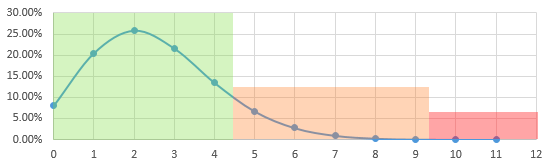

**Exemplo 5**. Pretendemos calcular o VaR diário a 1% para a Tesla de acordo com uma abordagem paramétrica, com dados para o último ano e aquilatar se este modelo iria passar o teste do semáforo de Basileia. Notemos que estamos a fazer uma análise dentro da amostra. Apesar disso, se por exemplo fizermos uma escolha desacertada para a distribuição que caracteriza os retornos, subestimando a probabilidade de eventos extremos, facilmente nos poderemos encontrar bastante fora da zona verda!

Como o ficheiro Tesla.csv não tem informação sobre datas, iremos utilizar as últimas 252 observações.  
1. Estimar o desvio-padrão da amostra
2. Assumir uma distribuição normal
3. Calcular o VaR, assumindo adicionalmente que $\mu_T$=0.
4. Calcular o número de exceções registadas face ao VaR que foi calculado em (3)
5. Classificar o número de exceções calculado em (4) de acordo com o teste do semáforo de Basileia   

In [ ]:
Tesla252 = Tesla[end-251:end]  # criar amostra selecionando as 252 mais recentes observações

In [ ]:
GRF.semaforo(Tesla252,0.01)

### 1.5.2. Teste de cobertura incondicional de Kupiec

Denotemos por T o número de observações, por N o número de exceções e como habitual por α o nível de significância associado ao VaR. O teste de cobertura incondicional de Kupiec é dado por,

In [ ]:
Kupiec(T, N, α) = -2 * log((1-α)^(T-N) * α^N) + 2 * log((1-N/T)^(T-N) * (N/T)^N);

tendo uma distibuição chi-quadrado com um grau de liberdade. A hipótese nula é de que o modelo de VaR é adequado. O valor crítico a 5.0% é dado por,

In [ ]:
zchi = quantile(Chisq(1),0.95)  # Calculamos o valor crítico a 5%

Se Kupiec > 3.841588 $\rightarrow$ rejeitamos modelo VaR

Se Kupied < 3.841588 $\rightarrow$ não rejeitamos modelo VaR

**Exemplo 6.** Será o nosso modelo muito simples para o VaR das ações Tesla criado no exercício 5. rejeitado pelo teste de cobertura incondicional de Kupiec?

In [ ]:
T = 252
N = 4
α = 0.01
TesteKupiec = Kupiec(T, N, α)

TesteKupec < 3.841588, donde que não rejeitamos o modelo criado para calcular o VaR das ações Tesla!

## Retornos: Regularidades Empíricas

* Caudas pesadas (*fat tails*)
* Agrupamentos de volatilidade (*volatility clusters*)
* Dependência não-linear

### Caudas pesadas

A existência de caudas pesadas (*fat tails*) sugere que se utilize outras distribuições, que não a Normal, com essa característica. Uma escolha popular é a distribuição T-Student com um número baixo de graus de liberdade.

#### Gráficos QQ

Uma forma visual de comparar a distribuição empírica com a distribuição teórica candidata à sua representação é através de gráficos quantil-quantil, ou mais abreviadamente QQ.

Se pretendemos aquilatar numa primeira abordagem em que medida os retornos da (i) JP Morgan, (ii) Procter & Gamble e (iii) Tesla são bem representados por uma distribuição Normal, podemos comparar através de gráficos QQ os quantis das distribuições empíricas dos retornos destas ações com os quantis de uma distribuição Normal com idêntica média e desvio-padrão. 

**Exemplo 7.** Pretendemos inspecionar visualmente se uma distribuição Normal proporcionará uma boa caracterização das séries cronológicas de retornos das acções da JP Morgan, Procter & Gamble e Tesla. Para tal vamos padronizar as distribuições empíricas dos retornos subtraindo a média e dividindo pelo desvio padrão.

In [ ]:
JPMorganP = (JPMorgan .- mean(JPMorgan))./std(JPMorgan);
PGP = (PG .- mean(PG))./std(PG);
TeslaP = (Tesla .- mean(Tesla))./std(Tesla);
# utilizamos o ponto para aplicar uma operação ou função elemento-a-elemento de um vetor

In [ ]:
qqplot(Normal(0, 1), JPMorganP, xlabel="Distribuição Normal(0,1)", 
    ylabel = "Distribuição Empírica JP Morgan Standardizada")

In [ ]:
qqplot(Normal(0, 1), PGP, xlabel="Distribuição Normal(0,1)", 
    ylabel = "Distribuição Empírica Procter & Gamble Standardizada")

In [ ]:
qqplot(Normal(0, 1), TeslaP, xlabel="Distribuição Normal(0,1)", 
    ylabel = "Distribuição Empírica Tesla Standardizada")

Podemos constatar que a probabilidade de eventos extremos nos retornos da JP Morgam, Procter & Gamble e Tesla são bastante superiores ao que uma distribuição Normal sugeriria.

Podemos ver se a situção melhora com a utilização de uma distribuição com caudas mais pesadas como uma distribuição T-Studant standard, neste caso com 5 graus de liberdade. 

In [ ]:
qqplot(TDist(5), JPMorganP,  xlabel = "Distribuição T-Student(5) Standard",
ylabel = "Distribuição Empírica JP Morgan Standardizada")
# TDist(5) representa uma distribuição T-Student standard com 5 graus de liberdade

In [ ]:
qqplot(TDist(5), PGP, xlabel = "Distribuição T-Student(5) Standard",
ylabel = "Distribuição Empírica Procter & Gamble Standardizada")

In [ ]:
qqplot(TDist(5), TeslaP, xlabel = "Distribuição T-Student(5) Standard",
ylabel = "Distribuição Empírica Tesla Standardizada")

Os gráficos Q-Q sugerem que uma distribuição T-Student com um número baixo de graus de liberdade poderá representar melhor o perfil de retornos observado para as ações da JP Morgan, Procter & Gamble e Tesla do que uma distribuição Normal. 

#### Testes de Normalidade

Iremos efetuar o teste de [Jarque-Bera](https://en.wikipedia.org/wiki/Jarque–Bera_test) para a hipótese nula de que os vetores de retornos da JP Morgan, Procter & Gamble e Tesla são normalmente distribuídos. Função em Julia: ```JarqueBeraTest(retornos)```

In [ ]:
JarqueBeraTest(JPMorgan)

In [ ]:
JarqueBeraTest(PG)

In [ ]:
JarqueBeraTest(Tesla)

Para a JP Morgan, Procter & Gamble e Tesla a hipótese nula de normalidade dos retornos é fortemente rejeitada.

### Agrupamentos de volatilidade

A existência de agrupamentos de volatilidade sugere que a utilização de volatilidades constantes possa conduzir a uma especificação errada para o processo dos retornos. Escolhas populares para ultrapassar este problema na previsão da volatilidade dos retornos são, a utilização de:
 * Estimação da volatilidade através de médias móveis ponderadas exponencialmente (EWMA)
 * Estimação da volatilidade através de modelos GARCH 
 * Extração de volatilidades implícitas do mercado de instrumentos derivados

#### Teste para presença de agrupamentos de volatilidade

Um teste estatístico formal para a presença de agrupamente de volatilidade é teste ARCH-LM de Engle. A estatística do teste segue uma distribuição chi-quadrado sob a hipótese nula de inexistência de agrupamentos de volatilidade. O teste de Engle pode ser realizado através da função: $\texttt{ARCHLMTest}$(*retornos*,*lag*)

In [ ]:
ARCHLMTest(JPMorgan,1)

In [ ]:
ARCHLMTest(PG,1)

In [ ]:
ARCHLMTest(Tesla,1)

Para qualquer uma das séries cronológicas de retornos da JP Morgan, Procter \& Gamble e Tesla, rejeitamos a inexistência de agrupamento de volatilidade.

#### Simulação histórica clássica: médias móveis simples

A determinação da volatilidade (ou variância) através de médias móveis simples corresponde a assumir-se que o contributo de cada observação para o seu valor é idêntico na janela de dados. Sendo ($m$) o número de dias na janela de dados utilizada e ($u_{t-k}$) a diferença entre o retorno ($r_{t-k}$) e a média de retornos ($\mu$), temos

$$\sigma^2_t = \frac{1}{m}\sum_{k=1}^m u_{t-k}^2, \qquad u_{t-k} = r_{t-k}-\mu$$

Todos os retornos quadráticos têm igual ponderação 1/m. Na volatilidade calculada através de médias móveis simples, um retorno muito recente não tem maior impacto no cálculo da volatilidade do que um retorno muito afastado.

**Exemplo**. Pretendemos estimar a volatilidade com médias móveis simples (MMS) para uma janela de dados correspondente ao último ano (252 observações).

In [ ]:
display(plot(JPMorgan[end-251:end], title = "Retornos diários JP Morgan", legend = false))
display(plot(PG[end-251:end], title = "Retornos diários Procter & Gamble", legend = false))
display(plot(Tesla[end-251:end], title = "Retornos diários Tesla", legend = false))
println("Volatilidade(JPMorgan) = ", std(JPMorgan[end-251:end]))
println("Volatilidade(Procter & Gamble) = ", std(PG[end-251:end]))
println("Volatilidade(Tesla) = ", std(Tesla[end-251:end]))

#### Médias móveis ponderadas exponencialmente

Nas médias móveis exponencialmente ponderadas, ou EWMA (*exponentially weighted moving average*), os retornos mais recentes têm uma mais elevada ponderação na determinação da variância. Os retornos quadráticos têm associado um parâmetro de alisamento $\lambda \in (0,1)$ que define ponderadores variáveis da seguinte forma,

$$\sigma^2_t =\sum_{k=1}^m(1-\lambda)\lambda^{k-1} \,u_{t-k}^2, \qquad u_{t-k} = r_{t-k}-\mu $$ 

Num documento influente, da [RiskMetrics](https://www.msci.com/documents/10199/5915b101-4206-4ba0-aee2-3449d5c7e95a), então parte da J.P.Morgan/Reuters, é sugerida a utilização do valor 0.94 para o parâmetro ($\lambda$) no caso de retornos diários. Assim, teríamos uma ponderação do retorno quadrático de (1-0.94)$\times$0.94$^0$ = 0.06 para a observação mais recente, para a observação seguinte de (1-0.94)$\times$0.94$^1$ = 0.0564. O retorno quadrático do terceiro dia mais recente teria uma ponderação igual a (1-0.94)$\times$0.94$^2$ = 0.053016.

A equação anterior pode ser expressa de uma forma recursiva equivalente através de,

$$\sigma^2_t = \lambda\,\sigma^2_{t-1} + (1-\lambda)\,u^2_{t-1}, \qquad u_{t-1} = r_{t-1}-\mu $$

Um parâmetro $\lambda$ mais elevado induz um decaimento mais vagaroso nos ponderadores da série cronológica. Pelo contrário, se reduzirmos o parâmetro $\lambda$ teremos um decaimento mais rápido.

In [ ]:
function EWMA(serie, lambda)
    m = length(serie)
    media = mean(serie)                 # calculamos a média dos retornos observados
    σ2 = 0
    for k in 1:m
        σ2 += (1-lambda)*lambda^(k-1) * (serie[end-k+1] - media)^2
    end
    return sqrt(σ2)                     # retornamos a volatilidade
end

**Exemplo 8.** Pretendemos comparar a volatilidade calculada por médias móveis simples com a volatilidade calculada através de médias móveis ponderadas exponencialmente (EWMA)

In [ ]:
println("σ(JP Morgan): MMS = ", std(JPMorgan), 
    ", EWMA = ", EWMA(JPMorgan, 0.94))

println("σ(Procter & Gamble): MMS = ", std(PG), 
    ", EWMA = ", EWMA(PG, 0.94))

println("σ(Tesla): MMS = ", std(Tesla), 
    ", EWMA = ", EWMA(Tesla, 0.94))

A JP Morgan está atualmente num regime de volatilidade mais baixo do que a média histórica, para a Procter & Gamble os niveis de volatildade são semelhantes e para a Tesla o atual regime de volatilidade ainda é mais alto do que a média histórica, já de si bastante alto.

#### Modelos GARCH

Os modelos GARCH (*generalized autoregressive conditional heteroskedasticity*) são frequentemente utilizados para modelizar séries cronológicas financeiras que evidenciam volatilidade temporalmente variável e agrupamentos de volatilidade e podem-se incluir na família de modelos de volatilidade estocástica.

O modelo GARCH(p,q), onde $p$ é a ordem dos termos GARCH em $\sigma^2$ e $q$ é a ordem dos termos GARCH em $u^2$, é dado por,

$$\sigma^2_t = \omega +  \sum_{k=1}^p \beta_{k} \sigma_{t-k}^2 + \sum_{k=1}^q \alpha_{k} u_{t-k}^2, \qquad u_{t-k} = r_{t-k}-\mu $$

Os modelos GARCH contituem uma generalização da equação utilizada pelo método EWMA. Envolvem também um processo de estimação repousando em hipóteses sobre a distribuição dos desvios dos retornos face à sua média, ao contrário do método EWMA. Os $p$ parâmetros $\alpha_k$ e $q$ parâmetros $\beta_k$ podem ser estimados econometricamente pela aplicação `ARCHModels` escrita em Julia. É o que faremos no exemplo seguinte.

**Exemplo 9.** Utilizando a aplicação `ARCHModels` pretendemos estimar modelos GARCH(1,1) para as séries cronológicas de retornos da JP Morgan, Procter & Gamble e Tesla e obter estimativas para a volatilidade, comparando estas com as volatilidades simples já anteriormente calculadas.

In [ ]:
gJPMorgan = fit(GARCH{1, 1}, JPMorgan)

In [ ]:
gPG = fit(GARCH{1, 1}, PG)

In [ ]:
gTesla = fit(GARCH{1, 1}, Tesla)

Os parâmetros $\hat{\alpha}_1$ e $\hat{\beta}_1$ estimados para a equação de volatilidade são altamente significantes, novamente confirmando a presença de agrupamentos de volatilidade.

Com base no modelo GARCH(1,1) estimado, vamos agora efetuar a previsão da volatilidade um-passo-à-frente para a JP Morgan, Procter & Gample e Tesla e comparar com a volatilidade calculada por médias móveis simples (MMS). A aplicação `ARCHModels` dispõe da função `predict`para previsão da volatilidade

In [ ]:
println("σ(JP Morgan): MMS = ", std(JPMorgan), 
    ", GARCH(1,1) = ", predict(gJPMorgan, :volatility))

println("σ(Procter & Gamble): MMS = ", std(PG), 
    ", GARCH(1,1) = ", predict(gPG, :volatility))

println("σ(Tesla): MMS = ", std(Tesla), 
    ", GARCH(1,1) = ", predict(gTesla, :volatility))

Se pretendermos a previsão da volatilidade n-passos-à-frente, com n = 3 fazemos,

In [ ]:
predict.(gTesla, :volatility, 1:3)

**Exemplo 10.** Vamos calcular o VaR assumindo que em vez de termos uma volatilidade constante na janela de dados dada pela pela média móvel simples ela é antes dada por um modelo GARCH(1,1) o qual, como vimos, é mais indicado para situações de agrupamento de volatilidade. O nível de signficância $\alpha$ é igual a 5.0% e o valor da carteira, constituída apenas por ações da Tesla, é uma unidade monetária.

In [ ]:
α = 0.05
V = 1
VaRs(gTesla, α) * V

Podemos também ver num gráfico as rendibilidades históricas observadas confrontadas com o valor do VaR para a Tesla. Os retornos estão apresentados como $-r_t$, isto é um retorno de -0.02 é uma perda de 0.02. O VaR vai agora evoluindo à medida que as estimativas da volatilidade um-passo-à-frente do modelo GARCH(1,1) se vão alterando

In [ ]:
plot(-Tesla, legend=:none, ylabel="Perdas")
plot!(VaRs(gTesla, 0.05) * V, color=:purple)      # VaR com α = 5.0%
plot!(VaRs(gTesla, 0.01) * V, color=:green)       # VaR com α = 1.0%

### Dependência não-linear

A existência de dependência não linear, em particular o fato da correlação entre séries de retornos não ser constante, sendo maior em momentos de maior turbulência do mercado, deve ser levada em conta aquando da modelização do risco de perda em portfólios.